# 일반화 모델

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import *
import shap
from sklearn.utils import resample

In [ ]:
df = pd.read_csv("data/seoul_preprocessed.csv")
df.head()

,SIG_KOR_NM,centroid_lat,centroid_lon,isSchool,rental_count,return_count,apart,closest_hospital_dist,closest_convenience_dist,closest_culture_dist,...,subway_avg_board,subway_avg_alight,area20,area30,area40,wp_area20,wp_area30,wp_area40,isCommercial,tow_count
0,강서구,37.555328,126.765147,0,0.0,0.0,0.0,0.983944,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,강서구,37.555768,126.765465,0,0.0,0.0,0.0,0.982132,0.998387,0.998759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,강서구,37.555308,126.766217,0,0.0,0.0,0.0,0.979761,0.996157,0.998000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,강서구,37.555945,126.766239,0,0.0,0.0,0.0,0.978807,0.995359,0.997008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,강서구,37.552600,126.768528,0,0.0,0.0,0.0,0.975325,0.986236,0.997992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [5]:
# 지역 기반 분할
train_df = df[df['SIG_KOR_NM'].isin(['영등포구', '도봉구','강북구', '중구', '강남구'])]
test_df  = df[df['SIG_KOR_NM'].isin(['노원구', '성북구'])]

In [ ]:
df_nonzero = train_df[train_df['tow_count'] > 0].copy()

# `tow_count` 값으로 정렬
df_nonzero = df_nonzero.sort_values(by='tow_count')

# 0을 제외한 데터터
total_nonzero = len(df_nonzero)

mid_end = int(total_nonzero*1/2) # 절반
mid_end_value = df_nonzero.iloc[mid_end - 1]['tow_count']  # 가운데 구간 끝값


print(f"가운데 구간 끝값: {mid_end_value}\n")

train_df['risk_level'] = train_df['tow_count'].apply(
    lambda x: 0 if x == 0 else (1 if x <= mid_end_value else 2)
)
test_df['risk_level'] = test_df['tow_count'].apply(
    lambda x: 0 if x == 0 else (1 if x <= mid_end_value else 2)
)

# 결과 확인
print(train_df[['tow_count', 'risk_level']].tail())

첫 번째 구간 끝값: 1
두 번째 구간 끝값: 3
가운데 구간 끝값: 2

       tow_count  risk_level
32865          0           0
32866          0           0
32867          0           0
32868          0           0
32869          0           0


In [9]:
# df_majority = train_df[train_df['risk_level'] == 0]
# df_minority = train_df[train_df['risk_level'] != 0]

# n_minority = len(df_minority)
# n_majority_target = int(n_minority/2)

# # 언더샘플링
# df_majority_downsampled = resample(df_majority,
#                                    replace=False,
#                                    n_samples=n_majority_target,
#                                    random_state=42)

# # 병합
# df_balanced = pd.concat([df_majority_downsampled, df_minority])

# # 셔플
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# train_df = df_balanced.copy()

# # 비율 확인
# print(df_balanced['risk_level'].value_counts(normalize=True))
# print(train_df.shape)

In [11]:
features = train_df.columns[3:-2]
target = 'risk_level'
del train_df['tow_count']
del test_df['tow_count']

# 테스트 데이터 준비
X_test, y_test   = test_df[features], test_df[target]

In [13]:
train = train_df.iloc[:,3:]

In [15]:
exp_clf = setup(data = train, target = target, session_id=42)

,Description,Value
0,Session id,42
1,Target,risk_level
2,Target type,Multiclass
3,Original data shape,"(8465, 28)"
4,Transformed data shape,"(8465, 28)"
5,Transformed train set shape,"(5925, 28)"
6,Transformed test set shape,"(2540, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best_model = compare_models()

In [17]:
lgbm = create_model('lightgbm', class_weight='balanced')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6644,0.7545,0.6644,0.7190,0.6880,0.2302,0.2349
1,0.6813,0.7687,0.6813,0.7101,0.6945,0.2268,0.2283
2,0.6847,0.7699,0.6847,0.7260,0.7030,0.2573,0.2604
3,0.6847,0.7888,0.6847,0.7365,0.7065,0.2820,0.2877
4,0.6762,0.7746,0.6762,0.7269,0.6977,0.2616,0.2665
5,0.7179,0.8086,0.7179,0.7518,0.7322,0.3319,0.3356
6,0.6807,0.7989,0.6807,0.7324,0.7031,0.2656,0.2703
7,0.6486,0.7550,0.6486,0.7149,0.6772,0.2120,0.2173
8,0.6706,0.7525,0.6706,0.7063,0.6865,0.2188,0.2211


In [18]:
tuned_lgbm = tune_model(lgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6695,0.7594,0.6695,0.7260,0.6933,0.2498,0.2555
1,0.6796,0.7529,0.6796,0.7245,0.6991,0.2544,0.2583
2,0.6813,0.7647,0.6813,0.7159,0.6964,0.2403,0.2428
3,0.6610,0.7782,0.6610,0.7148,0.6843,0.2236,0.2281
4,0.6526,0.7523,0.6526,0.7278,0.6831,0.2451,0.2536
5,0.7095,0.8072,0.7095,0.7411,0.7232,0.3075,0.3104
6,0.6892,0.7934,0.6892,0.7414,0.7115,0.2876,0.2929
7,0.6791,0.7623,0.6791,0.7315,0.7014,0.2626,0.2678
8,0.6807,0.7475,0.6807,0.7061,0.6924,0.2209,0.2221


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [19]:
final_model = finalize_model(tuned_lgbm)
prediction = predict_model(final_model, data = X_test)
prediction

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,isSchool,rental_count,return_count,apart,closest_hospital_dist,closest_convenience_dist,closest_culture_dist,age_20s,age_30s,age_40s,...,subway_avg_alight,area20,area30,area40,wp_area20,wp_area30,wp_area40,isCommercial,prediction_label,prediction_score
21325,0,0.0,0.0,0.0,0.886046,0.755266,0.697780,0.372811,0.316705,0.386422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9731
21326,0,0.0,0.0,0.0,0.895811,0.756885,0.676548,0.372811,0.316705,0.386422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9683
21327,0,0.0,0.0,0.0,0.856233,0.620427,0.721672,0.372811,0.316705,0.386422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9740
21328,0,0.0,0.0,0.0,0.896274,0.525927,0.356616,0.480430,0.427845,0.442651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9162
21329,0,0.0,0.0,0.0,0.886692,0.587554,0.570754,0.480430,0.427845,0.442651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36293,0,0.0,0.0,0.0,0.924078,0.785347,0.864737,0.752825,0.586725,0.638176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8527
36294,0,0.0,0.0,0.0,0.937201,0.773051,0.876047,0.752825,0.586725,0.638176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8542
36295,0,0.0,0.0,0.0,0.942357,0.769055,0.880281,0.752825,0.586725,0.638176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8910
36296,0,0.0,0.0,0.0,0.957233,0.789758,0.894272,0.752825,0.586725,0.638176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9622


In [ ]:
# from sklearn.metrics import accuracy_score

# accuracy = accuracy_score(y_test, prediction['prediction_label'])
# print(f"Accuracy: {accuracy:.4f}")
from sklearn.metrics import f1_score

f1 = f1_score(y_test, prediction['prediction_label'], average='weighted')
print(f"f1 Score: {f1:.4f}")

f1 Score: 0.6757


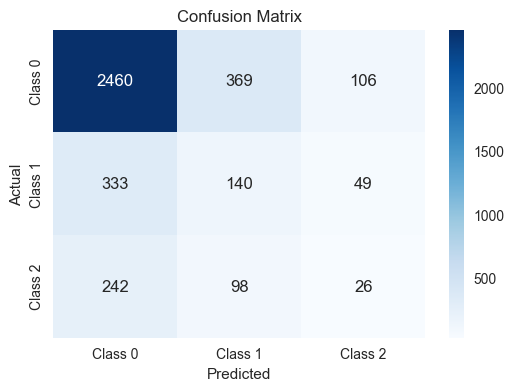

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 계산
cm = confusion_matrix(y_test, prediction['prediction_label'])

# 혼동 행렬 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

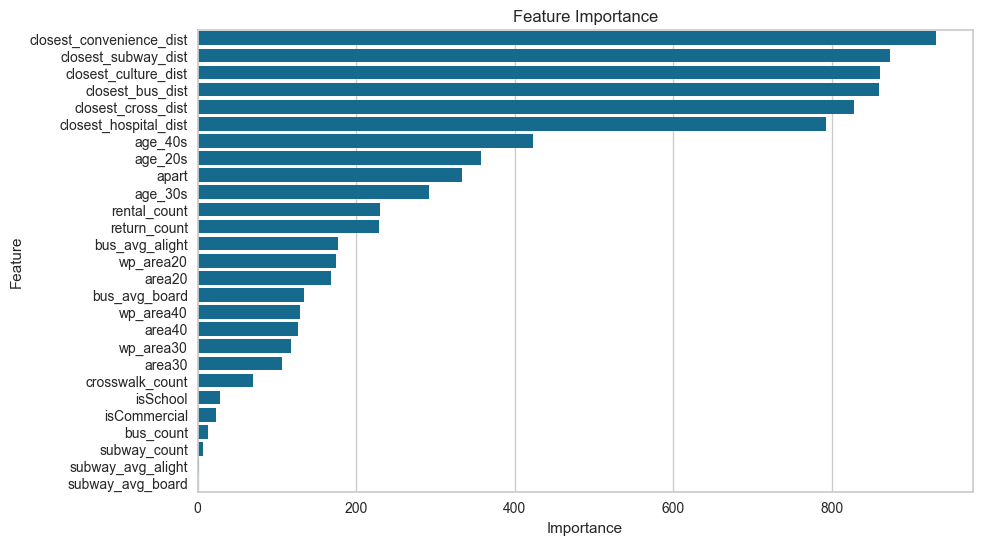

In [22]:
model_feature_importance = final_model.feature_importances_

# 중요도 값과 feature 이름을 함께 출력
features = get_config('X_train').columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': model_feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

클래스 0


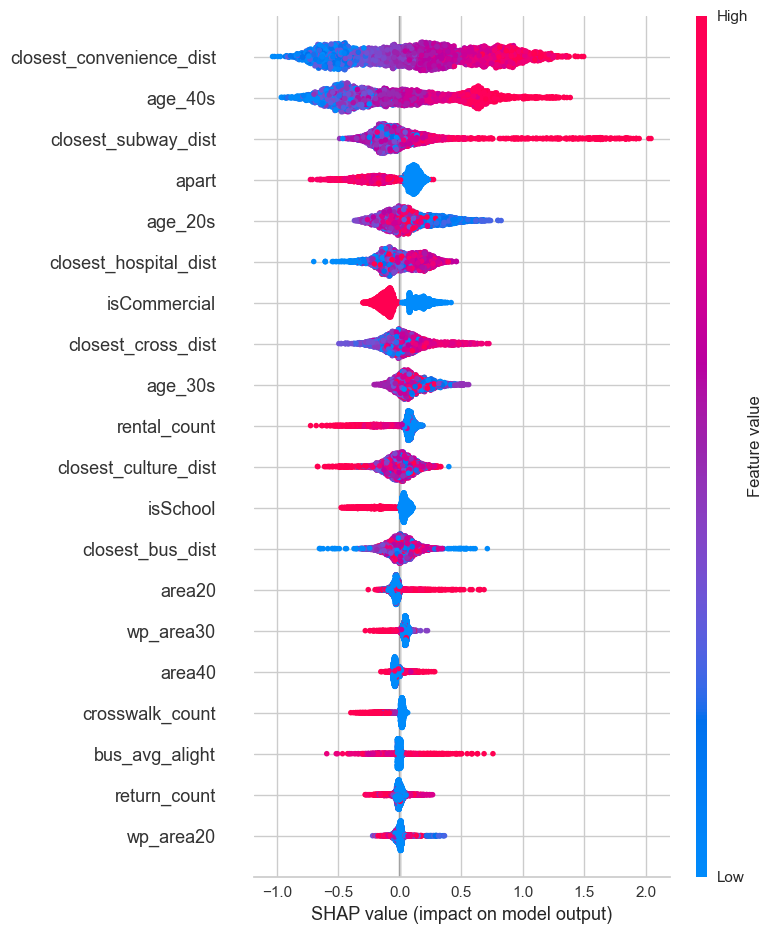

클래스 1


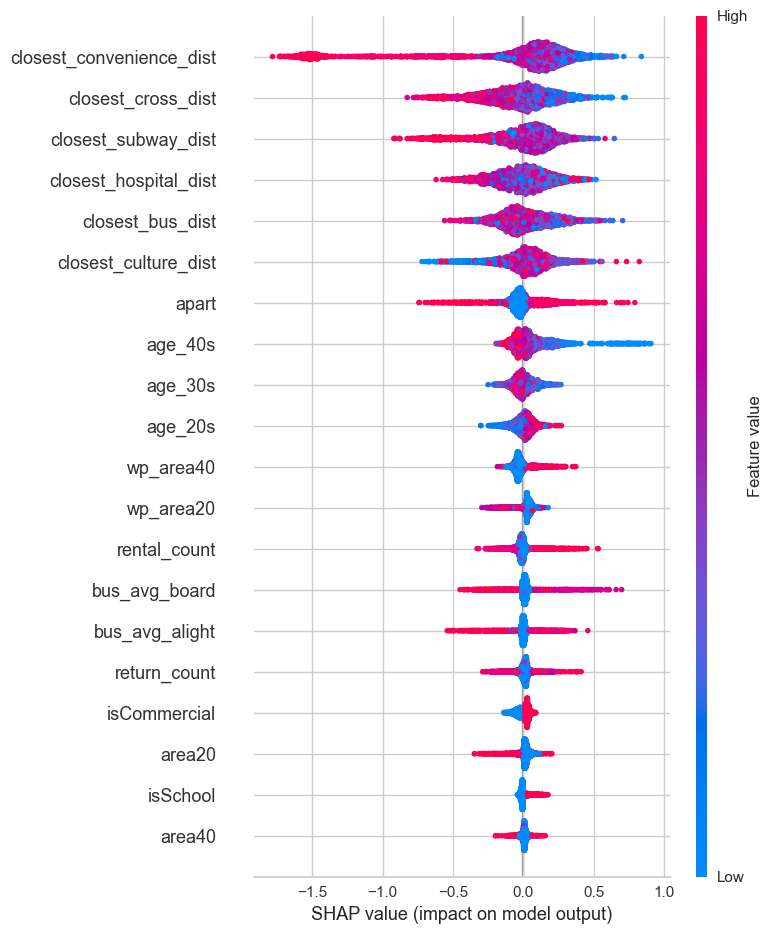

클래스 2


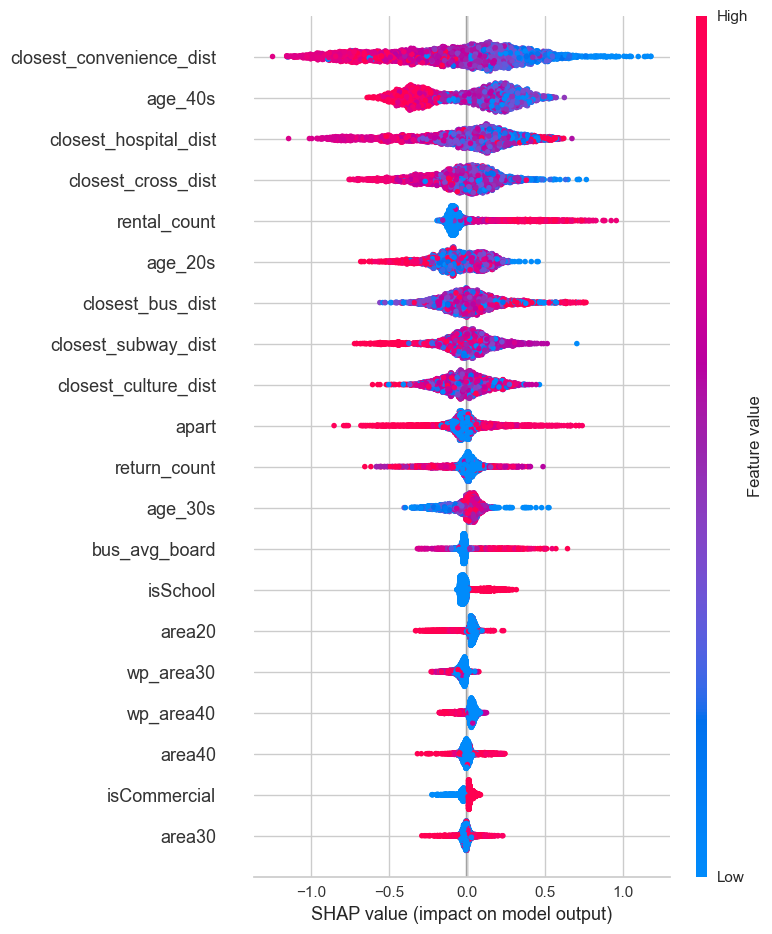

In [27]:
explainer = shap.Explainer(final_model.steps[-1][1])
shap_values = explainer(X_test)
for class_idx in range(shap_values.values.shape[2]):
    print(f"클래스 {class_idx}")
    shap.summary_plot(shap_values.values[:, :, class_idx], X_test)